In [1]:
logging(DevNull)

In [2]:
using Plots
pyplot(size=(640,360))

Plots.PyPlotBackend()

# Otimização Não-Linear na Linguagem Julia

## Abel Soares Siqueira
**Universidade Federal do Paraná, Curitiba**

![JuliaSmoothOptimizers](jso-small.png)

![julia](julia.png)

## Julia é uma linguagem de programação rápida e eficiente

- **Julia** tem sintaxe parecida com o do MatLab e do Python,
mas com performance muito superior;
- Julia permite a escrita técnica de alto-desempenho em uma única linguagem.
- Julia é uma linguagem nova, e não está na versão estável ainda (previsão do 1.0: 2018s1).
- Julia já está sendo adotada em cursos em todo o mundo.

Código tradicional

In [3]:
A = rand(10, 10)
L, U, P = lu(A)
b = A * ones(10)
x = U \ (L \ b[P])
norm(x - ones(10))

1.6954090725836824e-14

Código eficiente

In [4]:
A = rand(10, 10)
b = A * ones(10)
F = lufact(A) # Usa o LAPACK
x = F \ b
norm(x - ones(10))

4.951395542680039e-15

## Otimização Linear

\begin{align}
\min & \quad c^Tx \\
\mbox{s.a} & \quad Ax = b \\
& \quad x \geq 0.
\end{align}



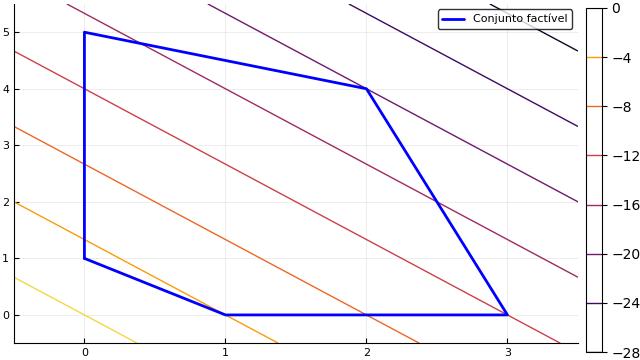

/home/abel/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label'
  s)


In [5]:
#=
  min -4x₁ - 3x₂
  s.a   x₁ +  x₂ ≧ 1
        x₁ + 2x₂ ≦ 10
       4x₁ +  x₂ ≦ 12
       x₁, x₂ ≧ 0
=#
contour(linspace(-0.5, 3.5, 100), linspace(-0.5, 5.5, 100), (x,y)->-4x-3y, levels=10)
plot!([0; 1; 3; 2; 0; 0],
      [1; 0; 0; 4; 5; 1], c=:blue, lw=2, lab="Conjunto factível")

xlims!(-0.5, 3.5)
ylims!(-0.5, 5.5)

In [6]:
function simplex(A, b, c; Ib = Int[], x = zeros(0))
    m, n = size(A)
    if length(Ib) == 0
        Atil = [A spdiagm(sign.(b), 0)]
        x, z, Ib, ef = simplex(Atil, b, [zeros(n); ones(m)],
                        Ib=collect(n+1:n+m), x=[zeros(n); sign.(b).*b])
        x = x[1:n]
        if z > 0
            return x, z, Ib[Ib .<= m], :infeasible
        end
    end
    In = setdiff(1:n, Ib)
    F = lufact(A[:,Ib])
    λ = F' \ c[Ib]
    sn = c[In] - A[:,In]' * λ
    ef = :optimal
    while any(sn .< 0)
        q = indmin(sn)
        d = F \ full(A[:,In[q]])
        if all(d .<= 0)
            ef = :unbounded
            break
        end
        p = indmin(d[i] > 0 ? x[Ib[i]] / d[i] : Inf for i = 1:m)
        xq = x[Ib[p]] / d[p]
        @views x[Ib] -= xq * d
        x[In[q]] = xq
        Ib[p], In[q] = In[q], Ib[p]
        F = lufact(A[:,Ib])
        λ = F' \ c[Ib]
        sn = c[In] - A[:,In]' * λ
    end
    return x, dot(x, c), Ib, ef
end

simplex (generic function with 1 method)

In [7]:
A = [1 1 -1 0 0;
     1 2  0 1 0;
     4 1  0 0 1]
b = [1; 10; 12]
c = [-4; -3; 0; 0; 0]
x, z, Ib, ef = simplex(A, b, c)

([2.0, 4.0, 5.0, 0.0, 0.0], -20.0, [1, 2, 3], :optimal)

## Otimização Não-Linear

### Irrestrita

$$ \min \quad f(x) $$

Exemplo: $$ f(x) = (1 - x_1)^2 + 100(x_2 - x_1^2)^2. $$


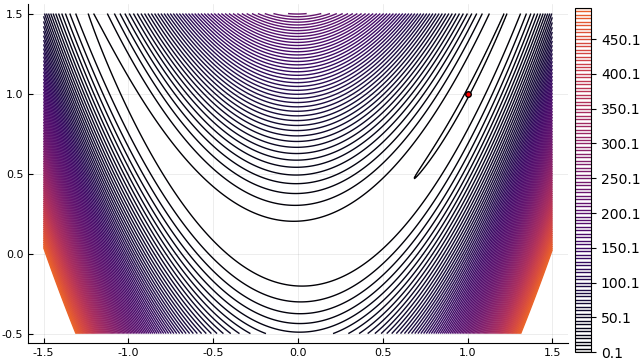

In [8]:
## Otimização Não Linear
contour(linspace(-1.5, 1.5, 400), linspace(-0.5, 1.5, 400), (x,y)->(1-x)^2 + 100*(y-x^2)^2, levels=[0.1:5.0:500])
scatter!([1.0], [1.0], c=:red, leg=false)

Dado $x_k$, aproximamos $f$ em torno de $x_k$ pelo modelo quadrático
$$ m_k(d) = f(x_k) + \nabla f(x_k)^T d + \frac{1}{2}d^T\nabla^2 f(x_k)d. $$

O mínimo de $m_k$, se $\nabla^2 f(x_k)$ for definida positiva, será $d$ que satisfaz o sistema
$$ \nabla^2 f(x_k) d = -\nabla f(x_k). $$

Método de Newton
$$\left\{\begin{array}{rcl}
    \nabla^2 f(x_k) d_k & = & -\nabla f(x_k) \\
    x_{k+1} & = & x_k + d_k.
\end{array}\right.$$

In [9]:
function newton(f, ∇f, H, x; tol = 1e-6, max_iter = 10_000)
    iter = 0
    while !(norm(∇f(x)) <= tol || iter > max_iter)
        d = -H(x) \ ∇f(x)
        x += d
        iter += 1
    end
    return x, f(x), iter
end

newton (generic function with 1 method)

In [10]:
f(x) = (1 - x[1])^2 + 100*(x[2] - x[1]^2)^2
∇f(x) = [2x[1] - 2 - 400*x[1]*(x[2] - x[1]^2);
         200*(x[2] - x[1]^2)]
H(x) = [2 - 400*x[2] + 1200*x[1]^2  -400*x[1];
        -400*x[1]  200]
newton(f, ∇f, H, [-1.2; 1.0])

([1.0, 1.0], 3.4326461875363225e-20, 6)

### Passos da pesquisa em desenvolvimento de algoritmos

- Ideia;
- Protótipo;
- Teoria;
- Implementação melhor;
- Testes computacionais em um conjunto de testes conhecidos.

**Julia** tem a velocidade e facilidade para que a prototipação e a implementação eficientes não sejam tão longe uma da outra.

Basta agora ferramentas de programação não-linear em Julia.

### Pacotes de otimização em Julia

- **JuMP**: Linguagem de modelagem matemática. Permite a descrição de um problema de uma maneira matemática;
- **Optim**: Pacote de otimização para o usuário final.
- **Clp, Cbc, Ipopt, Gurobi, CPLEX, etc.**: solvers em outras linguagens para serem usados em conjunto com o JuMP.

## JuliaSmoothOptimizers

![JuliaSmoothOptimizers](jso-small.png)

- Abel Soares Siqueira
- Dominique Orban
- Jean-Pierre Dussalt

![JuliaSmoothOptimizers](jso-graph.png)

- Para o desenvolvedor de softwares de otimização;
- O usuário cria seu algortimo para um tipo **AbstractNLPModel**;
- O código funciona para prototipação, exemplos prontos, testes por JuMP, e para testes de larga escala com o **CUTEst**;
- **LinearOperators** generalizam matrizes, para uso em algoritmos sem fatoração;
- **Krylov** implementa vários métodos de Krylov, em particular Gradientes Conjugados e Steihaug;
- **BenchmarkProfiles** contém o tradicional perfil de desempenho.
- **Optimize** contém funções auxiliares para desenvolvimento de algoritmos e alguns algoritmos prontos.

In [11]:
## Código usando NLPModels
using NLPModels
function newton(nlp::AbstractNLPModel; tol = 1e-6, max_iter = 10_000)
    x = nlp.meta.x0
    ∇f(x) = grad(nlp, x)
    iter = 0
    while !(norm(∇f(x)) <= tol || iter > max_iter)
        Hx = Symmetric(hess(nlp, x), :L)
        F = cholfact(Hx)
        d = -Hx \ ∇f(x)
        x += d
        iter += 1
    end
    return x, obj(nlp, x), iter
end

newton (generic function with 2 methods)

In [12]:
using NLPModels, JuMP
model = Model()
@variable(model, x[1:2])
setvalue(x, [-1.2; 1.0])
@NLobjective(model, Min, (1 - x[1])^2 + 100 * (x[2] - x[1]^2)^2)

nlp = MathProgNLPModel(model)
newton(nlp)

([1.0, 1.0], 3.4326461875363225e-20, 6)

In [13]:
nlp = ADNLPModel(x->(1 - x[1])^2 + 100 * (x[2] - x[1]^2)^2,
                 [-1.2; 1.0])
newton(nlp)

([1.0, 1.0], 3.4326461875363225e-20, 6)

In [14]:
using CUTEst

nlp = CUTEstModel("ROSENBR")
x, fx, iter = newton(nlp)
finalize(nlp)
x, fx, iter

([1.0, 1.0], 3.4326461875363225e-20, 6)

Nem tudo são flores

In [15]:
nlp = ADNLPModel(x->(1 - x[1])^2 + 100 * (x[2] - x[1]^2)^2,
                 [0.0; 1.0])
newton(nlp)

LoadError: [91mBase.LinAlg.PosDefException(1)[39m

Oh não, o método que fizemos em 20 segundos não é capaz de resolver problemas não convexos. :(

### Newton com região de confiança

Uma modificação da ideia:
- Manter um raio $\Delta_k > 0$ que indica confiança no modelo;
- Encontrar $d_k \approx \arg\min \{m_k(d) \ \mid\ \Vert d\Vert \leq \Delta_k\}$;
- Se o decréscimo em $f$ não for suficiente, escolher $\Delta_{k+1} < \Delta_k$ e manter $x_{k+1} = x_k$;
- Caso contrário, escolher $\Delta_{k+1} \geq \Delta_k$ e atualizar $x_{k+1} = x_k + d_k$.

Agora o modelo $m_k$ não precisa ser convexo e temos convergência global.

Para encontrar $d^k$, uma estratégia é utilizar o método de Steihaug, que é uma variação do Gradientes Conjugados.
Um ponto importante é que esse método faz apenas produtos entre a matriz Hessiana e vetores, não utilizando fatoração. Isso é bastante útil em larga escala.

### Método de Steihaug

$$ \min\quad \frac{1}{2}d^TBd + g^Td
\qquad \Vert d\Vert \leq \Delta. $$

- $z_0 = 0$, $r_0 = g$, $d_0 = -r_0$
- Para $j = 1, 2, \dots$
    - Se $(d_j)^T B d_j \leq 0$
        - Retorne $p_* = z_j + \tau d_k$ com $\Vert p_*\Vert = \Delta$
    - $\alpha = \dfrac{r_j^Tr_j}{d_j^TBd_j}$
    - $z_{j+1} = z_j + \alpha_j d_j$
    - Se $\Vert z_{j+1}\Vert \geq \Delta$
        - Retorne $p_* = z_j + \tau d_j$ com $\Vert p_*\Vert = \Delta$
    - $r_{j+1} = r_j + \alpha_j B d_j$
    - Se $\Vert r_{j+1} \Vert < \epsilon \Vert r_0 \Vert$
        - Retorne $p_* = z_{j+1}$
    - $\beta_{j+1} = \dfrac{r_{j+1}^Tr_{j+1}}{r_j^Tr_j}$
    - $d_{j+1} = -r_{j+1} + \beta_{j+1}d_j$

Já implementado no pacote **Krylov**

In [16]:
using Krylov
B = [10 1; 1 2]; g = B * ones(2)
cg(B, g) # Bd = g

([1.0, 1.0], 
Simple stats
  solved: true
  inconsistent: false
  residuals:  [  1.1e+01  1.3e+00  5.5e-16 ]
  Aresiduals: [ ]
  status: solution good enough given atol and rtol
)

In [17]:
cg(B, g, radius=0.5)

([0.482382, 0.131559], 
Simple stats
  solved: true
  inconsistent: false
  residuals:  [  1.1e+01  6.5e+00 ]
  Aresiduals: [ ]
  status: on trust-region boundary
)

In [18]:
m(d) = 0.5 * dot(d, B*d) - dot(d, g)
λ = dot(g,g) / dot(g, B*g)
t = linspace(0, 2pi, 60)
anim = Animation()
for Δ = linspace(0.8, 1.7, 91)
    contour(linspace(-0.5, 1.5, 100), linspace(-0.5, 1.5, 100),
            (x,y)->m([x;y]), leg=false)
    plot!(Δ * cos.(t), Δ * sin.(t), c=:green)
    d = cg(B, g, radius=Δ)[1]
    scatter!([d[1]], [d[2]], c=:purple, ms=5)
    xlims!(-0.2, 1.5)
    ylims!(-0.2, 1.5)
    frame(anim)
end
gif(anim, "ex1.gif")

Plots.AnimatedGif("/home/abel/projetos/abel/apresentacoes/2017-12-01-ufsc/ex1.gif")

In [19]:
B = [0.1 0.5; 0.5  1]; g = B * [1.0; 0.5]
m(d) = 0.5 * dot(d, B*d) - dot(d, g)
λ = dot(g,g) / dot(g, B*g); t = linspace(0, 2pi, 60)
anim = Animation()
for Δ = linspace(0.3, 2.0, 91)
    contour(linspace(-1.5, 1.5, 100), linspace(-1.5, 2.0, 100),
            (x,y)->m([x;y]), leg=false)
    plot!(Δ * cos.(t), Δ * sin.(t), c=:green)
    d = cg(B, g, radius=Δ)[1]
    scatter!([d[1]], [d[2]], c=:purple, ms=5)
    xlims!(-1.5, 1.5)
    ylims!(-0.2, 2.0)
    frame(anim)
end
gif(anim, "ex2.gif")

Plots.AnimatedGif("/home/abel/projetos/abel/apresentacoes/2017-12-01-ufsc/ex2.gif")

O algoritmo, nesse caso, não precisa da matriz $\nabla^2 f(x_k)$, apenas da transformação
$$ v \mapsto \nabla^2 f(x_k) v. $$

O pacote **LinearOperators** traz essa ferramenta, e o NLPModels faz uso dela.

In [20]:
using LinearOperators

T = LinearOperator(2, 2, true, # Simétrica?
                         true, # Hermitiana?
                         v -> [ 4v[1] + v[2]; v[1] + 2 * v[2]])
T * ones(2)

2-element Array{Float64,1}:
 5.0
 3.0

In [21]:
T' * ones(2)

2-element Array{Float64,1}:
 5.0
 3.0

In [22]:
full(T)

2×2 Array{Float64,2}:
 4.0  1.0
 1.0  2.0

In [23]:
b = T * ones(2)
cg(T, b)

([1.0, 1.0], 
Simple stats
  solved: true
  inconsistent: false
  residuals:  [  5.8e+00  5.5e-01  7.9e-16 ]
  Aresiduals: [ ]
  status: solution good enough given atol and rtol
)

In [24]:
nlp = ADNLPModel(x->(1 - x[1])^2 + 100 * (x[2] - x[1]^2)^2, [-1.2; 1.0])
Hx = hess_op(nlp, x)

Linear operator
  nrow: 2
  ncol: 2
  eltype: Float64
  symmetric: true
  hermitian: true
  prod:   NLPModels.#84
  tprod:  Nullable{Function}()
  ctprod: Nullable{Function}()


In [25]:
Hx * ones(2)

2-element Array{Float64,1}:
  402.0
 -200.0

In [26]:
function newton_trust_region(nlp::AbstractNLPModel; tol = 1e-6, max_iter = 10_000, η₁ = 1e-2, η₂ = 0.9, verbose=false)
    x = nlp.meta.x0
    f(x) = obj(nlp, x)
    ∇f(x) = grad(nlp, x)
    iter = 0
    Δ = 1.0
    while !(norm(∇f(x)) <= tol || iter > max_iter)
        Hx = hess_op(nlp, x)
        d = cg(Hx, -∇f(x), radius=Δ)[1]
        ρ = (f(x + d) - f(x)) / (0.5 * dot(d, Hx * d) + dot(d, ∇f(x)))
        if ρ < η₁
            Δ /= 2
        else
            if ρ > η₂
                Δ *= 2
            end
            x += d
        end
        iter += 1
    end
    return x, obj(nlp, x), iter
end

newton_trust_region (generic function with 1 method)

In [27]:
nlp = CUTEstModel("ROSENBR")
x, fx, iter = newton_trust_region(nlp)
finalize(nlp)
x, fx, iter

([1.0, 0.999999], 1.7991048837427194e-13, 30)

In [28]:
nlp = ADNLPModel(x->(1 - x[1])^2 + 100 * (x[2] - x[1]^2)^2,
                 [0.0; 1.0])
newton_trust_region(nlp)

([1.0, 1.0], 4.459420038980751e-15, 18)

In [29]:
nlp = CUTEstModel("OSCIGRAD")
println("nvar = $(nlp.meta.nvar)")
@time x, fx, iter = newton_trust_region(nlp)
finalize(nlp)
x, fx, iter

nvar = 100000
  6.363702 seconds (6.86 k allocations: 329.103 MiB, 0.57% gc time)


([-0.999857, 0.999929, 0.999964, 0.999982, 0.999991, 0.999996, 0.999998, 0.999999, 0.999999, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 5.4519932813187e-24, 15)

## LBFGS com busca linear

Outra opção, no lugar de fazer região de confiança, é usar uma aproximação BFGS para a Hessiana, calcular a direção e fazer busca linear.

**BFGS**
$$ [\nabla^2 f(x_k)]^{-1} \approx H_{k+1} = (I - \rho_ks_ky_k^T)H_k(I - \rho_ky_ks_k^T) + \rho_ks_ks_k^T, $$
onde
$$ s_k = x_{k+1} - x_k, \qquad y_k = \nabla f(x_{k+1}) - \nabla f(x_k), \qquad
\rho_k = \frac{1}{s_k^Ty_k}.
$$

**LBFGS:** Guarda apenas uma quantidade finita.

O algoritmo fica
$$ \left\{\begin{array}{rcl}
d_k & = & -H_k\nabla f(x_k) \\
x_{k+1} & = & x_k + t_k d_k
\end{array}
\right.$$
onde $t_k$ é escolhido para que
$$ f(x_{k+1}) < f(x_k) + \alpha t_kd_k^T\nabla f(x_k). $$

A implementação do BFGS armazena apenas os valores $s_k, y_k$ e $\rho_k$, e calcula o produto $H_k d$ de maneira eficiente. Além disso, apenas uma quantidade limitada de vetores é armazenada, e vetores antigos dão lugar a novos.

In [30]:
# LinearOperators também já tem esse operador
Hb = InverseLBFGSOperator(2)
Hb * ones(2)

2-element Array{Float64,1}:
 1.0
 1.0

In [31]:
s = [1.0; 2.0]
y = [-1.0; 4.0]
push!(Hb, s, y)
Hb * ones(2)

2-element Array{Float64,1}:
 2.46939
 1.36735

In [32]:
function bfgs_busca_linear(nlp::AbstractNLPModel; tol = 1e-6, max_iter = 10_000, α = 1e-2, verbose=false)
    x = nlp.meta.x0
    f(x) = obj(nlp, x)
    ∇f(x) = grad(nlp, x)
    Hx = InverseLBFGSOperator(length(x))
    iter = 0
    Δ = 1.0
    while !(norm(∇f(x)) <= tol || iter > max_iter)
        d = -Hx * ∇f(x)
        t = 1.0
        while !( f(x + t * d) < f(x) + α * t * dot(∇f(x), d) )
            t /= 2
            if t < 1e-12
                return x, f(x), iter
            end
        end
        y = ∇f(x + t * d) - ∇f(x)
        x += t * d
        push!(Hx, t * d, y)
        iter += 1
    end
    return x, f(x), iter
end

bfgs_busca_linear (generic function with 1 method)

In [33]:
nlp = CUTEstModel("ROSENBR")
x, fx, iter = bfgs_busca_linear(nlp)
finalize(nlp)
x, fx, iter

([1.0, 1.0], 3.676141960319036e-16, 35)

In [34]:
problems = sort(CUTEst.select(max_var=2, max_con=0, only_free_var=true))
mtds = [newton_trust_region, bfgs_busca_linear]
np = length(problems)
P = fill(-1, np, 2)
logfile = open("logfile.txt", "w")
for (i,p) in enumerate(problems)
    @printf(logfile, "%12s", p)
    nlp = CUTEstModel(p)
    F = fill(Inf, length(mtds))
    for (j,mtd) in enumerate(mtds)
        try
            x, fx, iter = mtd(nlp, max_iter = 1000)
            F[j] = fx
            P[i,j] = sum_counters(nlp)
            @printf(logfile, " %10.2e  %5d", fx, P[i,j])
        catch
            @printf(logfile, " %17s", "exception")
        end
        reset!(nlp)
    end
    finalize(nlp)
    @printf(logfile, "\n")
    fmin = minimum(F)
    for j = 1:length(mtds)
        if !(F[j] < fmin + abs(fmin) * 0.1 + 1e-3)
            P[i,j] = -1
        end
    end
end
close(logfile)

In [35]:
for line in readlines("logfile.txt")
    println(line)
end

       AKIVA   6.17e+00     50       -Inf    130
       BEALE   1.95e-16     58   6.64e-19    131
    BOXBODLS   1.17e+03    241   9.77e+03     32
      BRKMCC   1.69e-01     26   1.69e-01     66
     BROWNBS   0.00e+00    256   3.67e-27    397
       CLIFF   2.00e-01    196   2.00e-01    293
        CUBE   9.19e-17    330   6.02e-21    341
   DANWOODLS   4.32e-03     74   4.32e-03    310
    DENSCHNA   1.10e-23     50   1.51e-13     67
    DENSCHNB   1.31e-15     42   1.24e-13     60
    DENSCHNC   2.18e-20     82   1.83e-01    118
    DENSCHNF   6.51e-22     50   3.90e-20    172
        DJTL  -8.16e+03   7993  -8.95e+03   8810
      EXPFIT   2.41e-01    101   2.41e-01    136
       HAIRY   2.00e+01    743   2.00e+01    262
    HILBERTA   1.14e-30     24   5.23e-15     44
    HIMMELBB   1.20e-20     97   5.92e-20    120
    HIMMELBG   3.25e-19     55   1.23e-14     81
    HIMMELBH  -1.00e+00     31  -1.00e+00     57
       HUMPS   1.23e+02   7631   1.16e-12    513
      JENSMP   1.24e

In [36]:
using BenchmarkProfiles


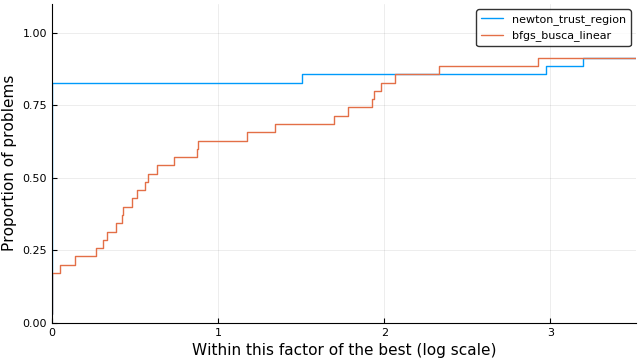

In [37]:
BenchmarkProfiles.performance_profile(P, string.(mtds))

## Métodos Implementados

O pacote **Optimize.jl** tem alguns métodos implementados e tem o objetivo de ter um método para cada tipo de problema com implementação de alta qualidade.

- `trunk`: Newton com região de confiança para minimização irrestrita
- `lbfgs`: L-BFGS com busca linear para minimização irrestrita
- `tron`: Pontos interiores para minimização em caixa

In [38]:
using Optimize

nlp = CUTEstModel("ROSENBR")
trunk(nlp)

([0.999773, 0.999545], 5.170179585068469e-8, 0.00020328781949276664, 21, true, false, "first-order stationary")

In [39]:
lbfgs(nlp)

([1.0, 1.0], 1.8247316356946387e-13, 1.8254550934225343e-5, 38, true, false, "first-order stationary")

In [40]:
tron(nlp)

([1.0, 1.0], 6.124055167140299e-15, 8.910006689729259e-8, 25, true, false, "first-order stationary", 0.7559289932250977)

In [41]:
finalize(nlp)


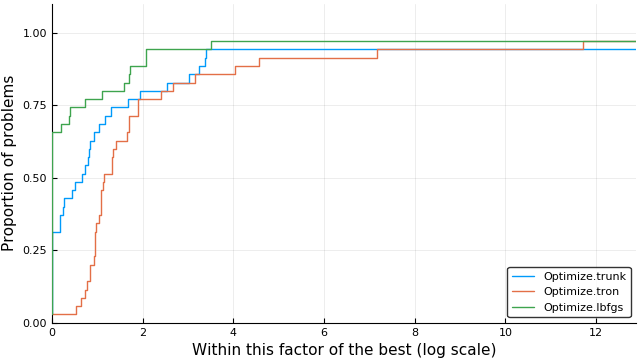

In [42]:
ps = sort(CUTEst.select(max_var=2, max_con=0, only_free_var=true))
problems = (CUTEstModel(p) for p in ps)
mtds = [trunk, lbfgs, tron]
stats, p = bmark_and_profile(mtds, problems)
p

## Projetos Futuros

- Implementação de outros solvers em larga escala;
- Uso do JSO em projetos
    - Otimização de Parâmetros
    - Métodos sem derivada para quadrados mínimos não-lineares

# Obrigado